Wanting to use etf's because things will average out between all the companies and not be too affected
by any one companies news/earnings reports. It might also be more stable and reliable than looking
at individual stocks.

In [1]:
import numpy as np
import pandas as pd
import json
import math 
import http.client
import time


from pandas import json_normalize

from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs

import seaborn as sns
import matplotlib.pyplot as plt

from random import random
from random import randint
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
def getCsv(ticker, region='US'):
    #options for region US|BR|AU|CA|FR|DE|HK|IN|IT|ES|GB|SG
    #note: cdz was actually cdz.to
    #index 0 is most recent
    conn = http.client.HTTPSConnection("apidojo-yahoo-finance-v1.p.rapidapi.com")

    headers = {
        'x-rapidapi-key': "REDACTED",
        'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com"
        }

    conn.request("GET", "/stock/v3/get-historical-data?symbol="+ticker.upper()+"&region="+region, headers=headers)

    res = conn.getresponse()
    data = res.read()

    result = data.decode("utf-8")
    j = json.loads(result)
    k = j["prices"]
    df = json_normalize(k)
    df.to_csv(ticker+'.csv')

In [55]:
def getCsv5(ticker, region='US'):
    #options for region US|BR|AU|CA|FR|DE|HK|IN|IT|ES|GB|SG
    #note: cdz was actually cdz.to
    #index 0 is most recent

    conn = http.client.HTTPSConnection("apidojo-yahoo-finance-v1.p.rapidapi.com")

    headers = {
        'x-rapidapi-key': "REDACTED",
        'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com"
        }

    conn.request("GET", "/stock/v2/get-historical-data?period1=1470524972&period2=1628291372&symbol="+ticker.upper()+"&frequency=1d&filter=history", headers=headers)

    res = conn.getresponse()
    data = res.read()
    result = data.decode("utf-8")
    j = json.loads(result)
    k = j["prices"]
    df = json_normalize(k)
    df.to_csv(ticker+'.csv')

In [146]:
class Stonk:
    Decimals = '.2f'
    def __init__(self, ticker):
        self.df = pd.read_csv(ticker+".csv")
        self.addColumns()
        self.ticker = ticker.upper()
    
    def highLowDiffFromRow(self, row):
        high = row['high']
        low = row['low']
        open = row['open']
        return (high-low)/open
    
    def dayOfWeekFromRow(self, row):
        epoch = row['date']
        return time.strftime('%A', time.localtime(epoch))
    
    def profitFromRow(self, row):
        openPrice = row['open']
        closePrice = row['close']
        return closePrice - openPrice
    
    def addColumns(self):
        self.df['weekday'] = self.df.apply (lambda row: self.dayOfWeekFromRow(row), axis=1)
        self.df['dayProfit'] = self.df.apply (lambda row: self.profitFromRow(row), axis=1)
        self.df['highLowDiff'] = self.df.apply (lambda row: self.highLowDiffFromRow(row), axis=1)
    
    def weekdayStats(self):
        
        result = pd.DataFrame(columns={'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'})

        
        df = self.df
        weekdays = [
            self.df[self.df['weekday']=='Monday'].dropna(subset=['open']),
            self.df[self.df['weekday']=='Tuesday'].dropna(subset=['open']),
            self.df[self.df['weekday']=='Wednesday'].dropna(subset=['open']),
            self.df[self.df['weekday']=='Thursday'].dropna(subset=['open']),
            self.df[self.df['weekday']=='Friday'].dropna(subset=['open'])
        ]

        
        pd.options.display.float_format = "{:,.2f}".format
        result.loc['Avg Volume (Mill)', :] = list(map(lambda weekday: weekday['volume'].sum()/weekday.shape[0]/1000000, weekdays))
        result.loc['Avg Open', :] = list(map(lambda weekday: weekday['open'].sum()/weekday.shape[0], weekdays))
        result.loc['Avg Close', :] = list(map(lambda weekday: weekday['close'].sum()/weekday.shape[0], weekdays))
        result.loc['Avg Profit', :] = list(map(lambda weekday: weekday['dayProfit'].sum()/weekday.shape[0], weekdays))
        result.loc['High/Low diff (%)', :] = list(map(lambda weekday: weekday['highLowDiff'].sum()/weekday.shape[0], weekdays))
        print(result)
    
    def logReg(self):
        #classify sell/hold/buy
        x, y, x_train, x_test, y_train, y_test = self.prepDataForClassification()
        logreg = LogisticRegression(max_iter = 10000)
        logreg.fit(x_train, y_train.values.ravel(), )
        y_pred = logreg.predict(x_test)
        accuracy_score(y_test, y_pred)
        print("accuracy: " + str(accuracy_score(y_test, y_pred)))
        print(confusion_matrix(y_test, y_pred))
        print(y_test)

    def linRegAndPlot(self, numOfDaysToTrainOn):
        #predict the prices
        x, y, x_train, x_test, y_train, y_test = self.prepData(numOfDaysToTrainOn)

        linreg = LinearRegression()
        linreg.fit(x_train, y_train.values.ravel(), )
        
        print(len(x_train))
        print(len(y_train))
        print(len(x_test))
        print(len(y_test))
        print(x_train)

        score = linreg.score(x_test, y_test)
        print('score'+str(score))

        predicted = linreg.predict(x_test)
        #plt.plot(np.arange(len(y)), np.flip(y), c = "g");
        
        #plt.plot(np.arange(len(y)-len(predicted),len(y)), np.flip(y_test), c = "g");
        #plt.plot(np.arange(len(y)-len(predicted),len(y)), np.flip(predicted), c = "r");
        L = range(len(predicted))
        L = L[::-1] 
        plt.plot(range(len(predicted)), y_test, c = "g");
        plt.plot(range(len(predicted)), predicted, c = "r");
        plt.legend(["actual", "predicted"], loc='best')
        plt.xlabel("Days Ago")
        plt.ylabel("Stock Price")
        plt.title("Predicted stock price of "+self.ticker+" based on past "+str(numOfDaysToTrainOn)+" trading days")
        plt.figtext(0, -0.1, 'Score: '+str(score))
        plt.figtext(0, -0.2, 'Average Difference: '+str(self.avgDiffBetween(y_test, predicted)))
        plt.gca().invert_xaxis()

        fig1 = plt.gcf()
        plt.draw()
        plt.savefig(self.ticker+str(numOfDaysToTrainOn)+'.png', dpi=100)
        plt.show
    
    def avgDiffBetween(self, a, b):
        sum = 0
        for i in range(len(a)):
            sum += abs(a[i]-b[i])
        return sum/len(a)
        
    def prepData(self, numOfDaysToTrainOn):
        df = self.df
        df = df.dropna(subset=['open']).reset_index()
                
        rowLen = numOfDaysToTrainOn
        hundred = pd.DataFrame(columns=np.arange(rowLen))
        for i in range(df.shape[0] - rowLen + 1):
            hundred.loc[i] = (df['close'].shift(-i)[0:rowLen])
        testSize = 50 #math.floor(df.shape[0] * 0.3)
        x = hundred.loc[:, hundred.columns != 0]
        y = hundred[0]

        x_test = x.head(testSize)
        x_train = x.tail(x.shape[0]-testSize)

        y_test = y[:testSize]
        y_train = y[testSize:]
        
        return [x, y, x_train, x_test, y_train, y_test]
    
    def prepDataForClassification(self):
        minPercentage = 0.01
        df = self.df
        df = df.dropna(subset=['open']).reset_index()

        rowLen = 100
        hundred = pd.DataFrame(columns=np.arange(rowLen))
        for i in range(df.shape[0] - rowLen + 1):
            hundred.loc[i] = (df['close'].shift(-i)[0:rowLen])
        
        hundred[0] = 1 - hundred[1]/hundred[0]
        hundred[0] = hundred[0].apply(self.status)
        testSize = math.floor(df.shape[0]*.3)
        print(testSize)
        x = hundred.loc[:, hundred.columns != 0]
        y = hundred[0]

        x_test = x.head(testSize)
        x_train = x.tail(x.shape[0]-testSize)

        y_test = y[:testSize]
        y_train = y[testSize:]
        
        return [x, y, x_train, x_test, y_train, y_test]
    
    def status(self, x):
        minPercentage = 0.02
        return "buy" if x > minPercentage else "sell" if x < (-minPercentage) else "hold"
    
    
    

In [147]:
stock = Stonk('spy')
stock.logReg()
#stock.linRegAndPlot(250)

377
accuracy: 0.7692307692307693
[[ 11   7   1]
 [ 11 273  45]
 [ 10  13   6]]
0      hold
1      hold
2      hold
3      hold
4      hold
       ... 
372    hold
373    hold
374    hold
375    hold
376    hold
Name: 0, Length: 377, dtype: object


1060
1060
100
100
              1           2           3           4           5           6   \
100   707.940002  693.729980  699.599976  668.059998  673.580017  563.000000   
101   693.729980  699.599976  668.059998  673.580017  563.000000  597.950012   
102   699.599976  668.059998  673.580017  563.000000  597.950012  621.440002   
103   668.059998  673.580017  563.000000  597.950012  621.440002  653.200012   
104   673.580017  563.000000  597.950012  621.440002  653.200012  686.440002   
...          ...         ...         ...         ...         ...         ...   
1155   43.397999   42.737999   42.936001   43.948002   43.905998   42.667999   
1156   42.737999   42.936001   43.948002   43.905998   42.667999   41.689999   
1157   42.936001   43.948002   43.905998   42.667999   41.689999   41.540001   
1158   43.948002   43.905998   42.667999   41.689999   41.540001   41.757999   
1159   43.905998   42.667999   41.689999   41.540001   41.757999   40.546001   

              7      

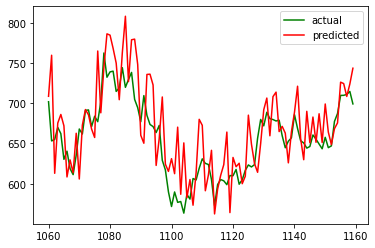

In [60]:
stock = Stonk('tsla')
#stock.logReg()
stock.linRegAndPlot()

score0.9934256168094378


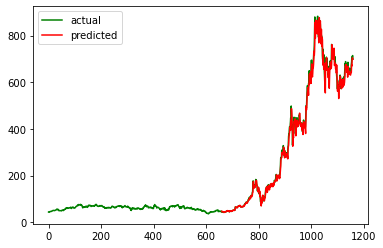

In [10]:
stock = Stonk('cdz.to')
stock.linRegAndPlot()

In [149]:
stock = Stonk('tsla')
print(stock.df)
stock.weekdayStats()

      Unnamed: 0        date   open   high    low  close        volume  \
0              0  1628280003 716.00 716.33 697.63 699.10 15,426,246.00   
1              1  1628170200 716.00 720.95 711.41 714.63 12,890,100.00   
2              2  1628083800 711.00 724.90 708.93 710.92 17,002,600.00   
3              3  1627997400 719.00 722.65 701.01 709.74 21,620,300.00   
4              4  1627911000 700.00 726.94 698.40 709.67 33,615,800.00   
...          ...         ...    ...    ...    ...    ...           ...   
1255        1255  1471008600  45.08  45.33  44.81  45.12  9,067,500.00   
1256        1256  1470922200  45.23  45.51  44.68  44.98  9,404,500.00   
1257        1257  1470835800  45.65  45.97  44.92  45.13 11,691,500.00   
1258        1258  1470749400  45.36  46.31  45.33  45.82 11,039,000.00   
1259        1259  1470663000  45.60  45.92  45.22  45.23 11,318,000.00   

      adjclose  numerator  denominator splitRatio type data    weekday  \
0       699.10        NaN          Na

                  Tuesday Wednesday Monday Friday Thursday
Avg Volume (Mill)   45.66     44.01  42.75  45.96    43.57
Avg Open           178.43    182.34 182.83 181.91   176.84
Avg Close          179.46    182.23 182.52 181.96   176.61
Avg Profit           1.03     -0.11  -0.32   0.04    -0.23
High/Low diff (%)    0.04      0.04   0.04   0.04     0.04
      index  Unnamed: 0        date   open   high    low  close        volume  \
0         0           0  1628280003 716.00 716.33 697.63 699.10 15,426,246.00   
1         1           1  1628170200 716.00 720.95 711.41 714.63 12,890,100.00   
2         2           2  1628083800 711.00 724.90 708.93 710.92 17,002,600.00   
3         3           3  1627997400 719.00 722.65 701.01 709.74 21,620,300.00   
4         4           4  1627911000 700.00 726.94 698.40 709.67 33,615,800.00   
...     ...         ...         ...    ...    ...    ...    ...           ...   
1254   1255        1255  1471008600  45.08  45.33  44.81  45.12  9,067,500.00  

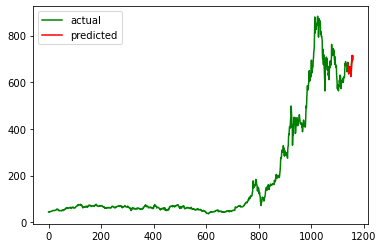

In [267]:
stock = Stonk('cdz.to')
stock.weekdayStats()
stock.linRegAndPlot()